# Graph constructing

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import pickle
from shapely import Polygon
import folium
from iduedu import (
    get_adj_matrix_gdf_to_gdf,
    get_all_public_transport_graph,
    get_drive_graph,
    get_intermodal_graph,
    join_pt_walk_graph
)
from iduedu.modules.drive_walk_builders import _build_edges_from_overpass, _get_highway_properties
from iduedu.enums.network_enums import Network
from iduedu.modules.graph_transformers import keep_largest_strongly_connected_component
from iduedu import config

In [2]:
LOCAL_CRS = "EPSG:32636"

In [3]:
context_boundary = gpd.read_file("../geojson/context_boundary.geojson").to_crs(LOCAL_CRS)

In [5]:
G_context_drive = get_drive_graph(territory=context_boundary, clip_by_territory=True)
G_context_intermodal = get_intermodal_graph(territory=context_boundary, clip_by_territory=True)

2025-12-12 13:04:41.126 | INFO     | Downloading drive network via Overpass ...
2025-12-12 13:04:41.143 | INFO     | Downloading network via Overpass done!
2025-12-12 13:04:41.585 | WARNING  | Removing 28 nodes from 5 smaller strongly connected components. These are subgraphs where nodes are internally reachable but isolated from the rest. Retaining only the largest strongly connected component (418 nodes).
2025-12-12 13:04:41.599 | INFO     | Downloading walk network via Overpass ...
2025-12-12 13:04:41.604 | INFO     | Downloading routes via Overpass with types tram, bus, trolleybus, subway ...
2025-12-12 13:04:41.645 | INFO     | Downloading network via Overpass done!
2025-12-12 13:04:41.691 | INFO     | Downloading routes via Overpass with types tram, bus, trolleybus, subway done!
Parsing public transport routes: 100%|██████████| 17/17 [00:01<00:00, 12.50it/s]
2025-12-12 13:04:44.009 | INFO     | Composing intermodal graph...
2025-12-12 13:04:44.485 | WARNING  | Removing 1 nodes fr

In [4]:
def walk_graph_from_edges(edges: gpd.GeoDataFrame, walk_speed: float = 5 * 1000 / 60):
    needed_tags = set(config.walk_useful_edges_attr)
    clip_poly_gdf = gpd.GeoDataFrame(geometry=[context_boundary.geometry.iloc[0]], crs=LOCAL_CRS)
    edges = edges.clip(clip_poly_gdf, keep_geom_type=True).explode(ignore_index=True)
    two_way = edges.copy()
    two_way.geometry = two_way.geometry.reverse()
    edges["_ord"] = np.arange(len(edges)) * 2
    two_way["_ord"] = np.arange(len(two_way)) * 2 + 1

    edges = (
        pd.concat([edges, two_way], ignore_index=True).sort_values("_ord").drop(columns="_ord").reset_index(drop=True)
    )

    coords = edges.geometry.get_coordinates().to_numpy()
    counts = edges.geometry.count_coordinates()
    cuts = np.cumsum(counts)
    first_idx = np.r_[0, cuts[:-1]]
    last_idx = cuts - 1
    starts = coords[first_idx]
    ends = coords[last_idx]
    edges["start"] = list(map(tuple, starts))
    edges["end"] = list(map(tuple, ends))

    all_endpoints = pd.Index(edges["start"]).append(pd.Index(edges["end"]))
    labels, uniques = pd.factorize(all_endpoints)
    n = len(edges)
    u = labels[:n]
    v = labels[n:]

    edges["length_meter"] = edges.geometry.length.round(3)
    edges["time_min"] = (edges["length_meter"] / float(walk_speed)).round(3)
    edges["type"] = "walk"

    graph = nx.MultiDiGraph()
    graph.add_nodes_from((i, {"x": float(x), "y": float(y)}) for i, (x, y) in enumerate(uniques))

    edge_attrs = set(needed_tags)
    edge_attrs |= {"geometry"}
    edge_attrs |= {"length_meter", "time_min", "type"}
    edge_attrs = [attr for attr in edge_attrs if attr in edges.columns]

    attrs_iter = edges[edge_attrs].to_dict("records")
    graph.add_edges_from((int(uu), int(vv), d) for uu, vv, d in zip(u, v, attrs_iter))

    # graph = keep_largest_strongly_connected_component(graph)

    mapping = {old: new for new, old in enumerate(graph.nodes())}
    graph = nx.relabel_nodes(graph, mapping)
    graph.graph["crs"] = edges.crs
    graph.graph["walk_speed"] = float(walk_speed)
    graph.graph["type"] = "walk"

    return graph

def drive_graph_from_edges(edges: gpd.GeoDataFrame):
    needed_tags = set(config.drive_useful_edges_attr)
    clip_poly_gdf = gpd.GeoDataFrame(geometry=[context_boundary.geometry.iloc[0]], crs=LOCAL_CRS)
    edges = edges.clip(clip_poly_gdf, keep_geom_type=True)

    if "oneway" not in edges.columns:
        two_way = edges.copy()
    else:
        two_way = edges[edges["oneway"] != "yes"].copy()
    two_way.geometry = two_way.geometry.reverse()
    edges = pd.concat([edges, two_way], ignore_index=True)

    coords = edges.geometry.get_coordinates().to_numpy()
    counts = edges.geometry.count_coordinates()
    cuts = np.cumsum(counts)
    first_idx = np.r_[0, cuts[:-1]]
    last_idx = cuts - 1
    starts = coords[first_idx]
    ends = coords[last_idx]
    edges["start"] = list(map(tuple, starts))
    edges["end"] = list(map(tuple, ends))

    all_endpoints = pd.Index(edges["start"]).append(pd.Index(edges["end"]))
    labels, uniques = pd.factorize(all_endpoints)
    n = len(edges)
    u = labels[:n]
    v = labels[n:]
    edges["u"] = u
    edges["v"] = v

    edges[["category", "maxspeed_mpm"]] = edges["highway"].apply(lambda h: pd.Series(_get_highway_properties(h)))

    if "maxspeed" in edges.columns:
        maxspeed_osm_mpm = (pd.to_numeric(edges["maxspeed"], errors="coerce") * 1000.0 / 60.0).round(3)
        edges["speed_mpm"] = maxspeed_osm_mpm.fillna(edges["maxspeed_mpm"])
    else:
        edges["speed_mpm"] = edges["maxspeed_mpm"]

    edges["length_meter"] = edges.geometry.length.round(3)
    edges["time_min"] = (edges["length_meter"] / edges["speed_mpm"]).round(3)
    edges["type"] = "drive"

    graph = nx.MultiDiGraph()

    graph.add_nodes_from((i, {"x": float(x), "y": float(y)}) for i, (x, y) in enumerate(uniques))

    needed_tags |= {"category"}
    needed_tags |= {"geometry"}
    needed_tags |= {"length_meter", "time_min", "type"}
    edge_attr_cols = list(tag for tag in needed_tags if tag in edges.columns)
    attrs_iter = edges[edge_attr_cols].to_dict("records")
    graph.add_edges_from((int(uu), int(vv), d) for uu, vv, d in zip(u, v, attrs_iter))

    graph = keep_largest_strongly_connected_component(graph)

    mapping = {old: new for new, old in enumerate(graph.nodes())}
    graph = nx.relabel_nodes(graph, mapping)
    graph.graph["crs"] = edges.crs
    graph.graph["type"] = "drive"

    return graph

In [92]:
context_drive_edges = _build_edges_from_overpass(
    polygon=context_boundary.to_crs("EPSG:4326").geometry.iloc[0],
    way_filter=Network.DRIVE.filter,
    needed_tags=set(config.drive_useful_edges_attr) | {"oneway", "maxspeed", "highway"},
    simplify=True
)
context_walk_edges = _build_edges_from_overpass(
    polygon=context_boundary.to_crs("EPSG:4326").geometry.iloc[0],
    way_filter=Network.WALK.filter,
    needed_tags=set(config.walk_useful_edges_attr),
    simplify=True
)

2025-12-14 14:33:34.545 | INFO     | iduedu.modules.drive_walk_builders:_build_edges_from_overpass:98 - Downloading network via Overpass done!
2025-12-14 14:33:35.068 | INFO     | iduedu.modules.drive_walk_builders:_build_edges_from_overpass:98 - Downloading network via Overpass done!


In [18]:
context_drive_edges[0].to_file("../geojson/context_drive_edges.geojson")
context_walk_edges[0].to_file("../geojson/context_walk_edges.geojson")

In [ ]:
project_walk_edges = gpd.read_file("../geojson/project_walk_edges.geojson").to_crs(LOCAL_CRS)

In [271]:
G_project_pt = get_all_public_transport_graph(territory=context_boundary, clip_by_territory=True)
G_project_walk = walk_graph_from_edges(project_walk_edges)
G_project_intermodal = join_pt_walk_graph(G_project_pt, G_project_walk)

2025-12-14 15:46:25.204 | INFO     | iduedu.modules.public_transport_builders:_get_public_transport_graph:273 - Downloading routes via Overpass with types tram, bus, trolleybus, subway ...
2025-12-14 15:46:25.333 | INFO     | iduedu.modules.public_transport_builders:_get_public_transport_graph:275 - Downloading routes via Overpass with types tram, bus, trolleybus, subway done!


Parsing public transport routes:   0%|          | 0/17 [00:00<?, ?it/s]

2025-12-14 15:46:28.358 | INFO     | iduedu.modules.intermodal_builders:join_pt_walk_graph:67 - Composing intermodal graph...
2025-12-14 15:46:37.688 | WARNING  | iduedu.modules.graph_transformers:keep_largest_strongly_connected_component:80 - Removing 29 nodes from 10 smaller strongly connected components. These are subgraphs where nodes are internally reachable but isolated from the rest. Retaining only the largest strongly connected component (1718 nodes).


In [44]:
with open('../pickle/project_intermodal_graph.gpickle', 'wb') as f:
    pickle.dump(G_project_intermodal, f, pickle.HIGHEST_PROTOCOL)

# Matrix test

In [6]:
from objectnat import get_service_provision, clip_provision

In [8]:
buildings = gpd.read_file("../geojson/all_building.geojson").to_crs(LOCAL_CRS)
services = gpd.read_file("../geojson/all_school.geojson").to_crs(LOCAL_CRS)

In [10]:
with open("../pickle/project_intermodal_graph.gpickle", "rb") as f:
    G_project_intermodal = pickle.load(f)
with open("../pickle/project_drive_graph.gpickle", "rb") as f:
    G_project_drive = pickle.load(f)

In [9]:
adjacency_matrix: pd.DataFrame = get_adj_matrix_gdf_to_gdf(
    gdf_from=buildings,
    gdf_to=services,
    nx_graph=G_context_intermodal,
    weight="time_min",
    threshold=45
)

In [10]:
buildings = buildings[buildings.population.notna()]
buildings["demand"] = np.floor(120 * buildings.population / 1000)
buildings = buildings.drop(buildings.columns.difference(["demand", "population", "geometry"]), axis=1)

In [11]:
buildings_prov, services_prov, links_prov = get_service_provision(
    buildings=buildings,
    services=services,
    adjacency_matrix=adjacency_matrix,
    threshold=15
)

In [12]:
m = buildings_prov.reset_index().explore(column="avg_dist", cmap="RdYlGn_r", tiles="CartoDB positron")
services_prov.explore(m=m, color="red")

# Imputing

In [175]:
from blocksnet.preprocessing.imputing import impute_buildings, impute_population

In [177]:
all_buildings = gpd.read_file("../geojson/all_building_reduced.geojson").to_crs(LOCAL_CRS).rename(columns={
    "building:levels": "number_of_floors"
})
context_buildings = all_buildings[all_buildings["population"].isna()]

In [179]:
context_buildings = impute_buildings(context_buildings)
context_buildings["population"] = 0
context_buildings[["living_area", "population"]] = impute_population(context_buildings, 10_000)

2025-12-12 16:03:06.339 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column footprint_area not found and will be initialized as None
2025-12-12 16:03:06.357 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column build_floor_area not found and will be initialized as None
2025-12-12 16:03:06.359 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column living_area not found and will be initialized as None
2025-12-12 16:03:06.362 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column non_living_area not found and will be initialized as None
2025-12-12 16:03:16.865 | INFO     | blocksnet.preprocessing.imputing.population.core:impute_population:47 - Distributing 10000 population between 2174 rows


# Metrics

In [1]:
import pickle
import numpy as np
import geopandas as gpd
from iduedu import get_adj_matrix_gdf_to_gdf, get_intermodal_graph, get_drive_graph, get_walk_graph
from objectnat import get_service_provision
from typing import Literal
from heapq import heappop, heappush
from typing import Any, Iterable, Literal

import networkx as nx
import numba as nb
import pandas as pd
from pyproj import CRS
from pyproj.exceptions import CRSError
from scipy.spatial import KDTree

from iduedu import config
from iduedu.modules.graph_transformers import keep_largest_strongly_connected_component
from iduedu.modules.matrix.numba_csr_matrix import UI32CSRMatrix

from iduedu.modules.matrix.matrix_builder import get_closest_nodes, _get_sparse_row, _get_numba_matrix_attr, dijkstra_numba_parallel
import folium

In [60]:
LOCAL_CRS = "EPSG:32636"

In [61]:
context_boundary = gpd.read_file("../geojson/context_boundary.geojson").to_crs(4326)

In [110]:
project_buildings = gpd.read_file("../geojson/project_residential_building.geojson").to_crs(LOCAL_CRS)

context_services = gpd.read_file("../geojson/all_kindergarten.geojson").to_crs(LOCAL_CRS).iloc[:3]
project_services = gpd.read_file("../geojson/all_kindergarten.geojson").to_crs(LOCAL_CRS)

with open("../pickle/context_intermodal_graph.gpickle", "rb") as context, \
        open("../pickle/project_intermodal_graph_with_bus.gpickle", "rb") as project:
    G_context_intermodal = pickle.load(context)
    G_project_intermodal = pickle.load(project)

In [111]:
def get_adj_matrix_gdf_to_gdf(
    gdf_from: gpd.GeoDataFrame,
    gdf_to: gpd.GeoDataFrame,
    nx_graph: nx.Graph,
    weight: Literal["length_meter", "time_min"] = "length_meter",
    dtype: np.dtype = np.float16,
    add_dist_tofrom_node=True,
    threshold: int = None,
    max_workers: int = None,
) -> pd.DataFrame:
    """
    Compute a shortest-path matrix between two GeoDataFrames over a weighted NetworkX graph.

    Each origin (row of `gdf_from`) and destination (column of `gdf_to`) is snapped to its nearest
    graph node (KD-tree), then distances are computed with a batched, Numba-parallel Dijkstra on
    the graph’s CSR matrix. Result units follow `weight`:
    - `"length_meter"` → meters,
    - `"time_min"` → minutes.

    Parameters:
        gdf_from (gpd.GeoDataFrame): Origin geometries (any types; snapped via representative points).
        gdf_to (gpd.GeoDataFrame): Destination geometries.
        nx_graph (nx.Graph): Graph with `graph["crs"]` and per-edge `weight` attribute present.
        weight ({"length_meter", "time_min"}): Edge attribute to minimize.
        dtype (np.dtype): Output matrix dtype (default `np.float16` to save memory).
        add_dist_tofrom_node (bool): If True, adds straight-line distances from origin geometry → its snap node
            and from snap node → destination geometry:
            - if `weight="length_meter"`: meters are added,
            - if `weight="time_min"`: meters converted to minutes assuming 5 km/h (~83.33 m/min).
        threshold (int | None): Optional max path threshold in `weight` units; longer paths are treated as missing.
            Internally quantized by ×100 for integer CSR; `None` ⇒ no cutoff.
        max_workers (int | None): If set, limits Numba thread count (`nb.set_num_threads(max_workers)`).

    Returns:
        (pd.DataFrame): Matrix with index = `gdf_from.index`, columns = `gdf_to.index`.
            Values are shortest-path distances; unreachable pairs are `np.inf`.

    Raises:
        ValueError: If the graph lacks `graph["crs"]`.
        CRSError: If the graph CRS is invalid or reprojection fails.

    Notes:
        - The graph is first pruned to its largest strongly connected component to avoid spurious `∞`.
        - For performance, if `len(gdf_from) > len(gdf_to)`, the computation is performed transposed and flipped back.
        - Internally, edge weights are converted to **uint32** by multiplying by 100; results are divided by 100
          before returning.
    """
    try:
        local_crs = nx_graph.graph["crs"]
    except KeyError as exc:
        raise ValueError("Graph does not have crs attribute") from exc

    try:
        gdf_from = gdf_from.to_crs(nx_graph.graph["crs"])
        gdf_to = gdf_to.to_crs(nx_graph.graph["crs"])
    except CRSError as e:
        raise CRSError(f"Graph crs ({local_crs}) has invalid format.") from e

    nx_graph = nx.convert_node_labels_to_integers(nx_graph)
    transposed = False

    if gdf_from.equals(gdf_to):
        closest_nodes_from, dist_from = get_closest_nodes(gdf_from, nx_graph)
        closest_nodes_to, dist_to = closest_nodes_from, dist_from
        sparse_row_scipy = _get_sparse_row(nx_graph, weight)
    else:
        dif = len(gdf_from) - len(gdf_to)
        if dif <= 0:  # straight
            closest_nodes_from, dist_from = get_closest_nodes(gdf_from, nx_graph)
            closest_nodes_to, dist_to = get_closest_nodes(gdf_to, nx_graph)
            sparse_row_scipy = _get_sparse_row(nx_graph, weight)

        else:  # reversed
            transposed = True
            closest_nodes_from, dist_from = get_closest_nodes(gdf_to, nx_graph)
            closest_nodes_to, dist_to = get_closest_nodes(gdf_from, nx_graph)
            sparse_row_scipy = _get_sparse_row(nx_graph, weight).transpose().tocsc().tocsr()

    csr_matrix = UI32CSRMatrix(*_get_numba_matrix_attr(sparse_row_scipy))
    del sparse_row_scipy

    if max_workers is not None:
        nb.set_num_threads(max_workers)

    # *** Warm-up ***
    dijkstra_numba_parallel(
        numba_matrix=csr_matrix,
        sources=np.array(closest_nodes_to[:1], dtype=np.int32),
        targets=np.array(closest_nodes_from[:1], dtype=np.int32),
        cutoff=np.int32(0),
    )

    if threshold is None:
        threshold = np.iinfo(np.int32).max
    else:
        threshold = threshold * 100

    adj_matrix = dijkstra_numba_parallel(
        numba_matrix=csr_matrix,
        sources=np.array(closest_nodes_from, dtype=np.int32),
        targets=np.array(closest_nodes_to, dtype=np.int32),
        cutoff=np.int32(threshold),
    )
    if transposed:
        adj_matrix = adj_matrix.transpose()

    adj_matrix = pd.DataFrame(adj_matrix / 100, columns=gdf_to.index, index=gdf_from.index, dtype=dtype)
    if add_dist_tofrom_node:
        if weight == "time_min":
            speed = 5 * 1000 / 60
            dist_to = dist_to / speed
            dist_from = dist_from / speed
        dist_from_matrix = np.array(dist_from)[:, np.newaxis]
        dist_to_matrix = np.array(dist_to)[np.newaxis, :]
        mask = adj_matrix > 0
        additional_matrix = (dist_from_matrix + dist_to_matrix).astype(dtype)
        if transposed:
            additional_matrix = additional_matrix.transpose()
        adj_matrix[mask] += additional_matrix
    return adj_matrix.where(adj_matrix >= 0, np.inf)

In [112]:
def stochastic_round(x):
    x = np.asarray(x)
    floor = np.floor(x)
    frac = x - floor
    rnd = np.random.rand(*x.shape)
    return floor + (rnd < frac)

In [113]:
project_boundary = gpd.read_file("../geojson/project_boundary.geojson").to_crs(LOCAL_CRS)

In [114]:
project_buildings["demand"] = stochastic_round(project_buildings["population"] * 61 / 1000)
context_buildings = project_buildings[~project_buildings.geometry.within(project_boundary.geometry.iloc[0])].reset_index()

In [115]:
context_adj_matrix = get_adj_matrix_gdf_to_gdf(
    context_buildings,
    context_services,
    G_context_intermodal,
    weight="time_min",
    threshold=45
)
project_adj_matrix = get_adj_matrix_gdf_to_gdf(
    project_buildings,
    project_services,
    G_project_intermodal,
    weight="time_min",
    threshold=45
)

In [116]:
context_prov = get_service_provision(
    context_buildings,
    context_adj_matrix,
    context_services,
    threshold=15
)
project_prov = get_service_provision(
    project_buildings,
    project_adj_matrix,
    project_services,
    threshold=15
)

In [117]:
m_context = (
    context_prov[0]
    .reset_index()
    .rename(columns={"avg_dist": "Среднее время в пути"})
    .explore(column="Среднее время в пути", cmap="RdYlGn_r", tiles="CartoDB positron")
)

m_context.fit_bounds([[60.03484356073069, 30.681551201702565], [60.061540858322765, 30.756738884808033]])

context_prov[1].explore(m=m_context, color="red").save("../html/context_provision_kindergarten.html")

In [118]:
m_project = (
    project_prov[0]
    .reset_index()
    .rename(columns={"avg_dist": "Среднее время в пути"})
    .explore(column="Среднее время в пути", cmap="RdYlGn_r", tiles="CartoDB positron")
)

img = folium.raster_layers.ImageOverlay(
    name="base_map",
    image="../png/base_map_geo.png",
    bounds=[[60.03532470, 30.70157978], [60.05335255, 30.73901616]],
    opacity=0.5,
    interactivity=True,
    cross_origin=False,
    zindex=1
)
img.add_to(m_project)

m_project.fit_bounds([[60.03484356073069, 30.681551201702565], [60.061540858322765, 30.756738884808033]])

project_prov[1].explore(m=m_project, color="red").save("../html/project_provision_kindergarten.html")

# PT modification

In [87]:
from iduedu.enums import PublicTrasport
from iduedu.modules.overpass_downloaders import get_routes_by_poly
from iduedu.modules.graph_transformers import estimate_crs_for_bounds
from iduedu import config
from tqdm.auto import tqdm
from iduedu.modules.overpass_parsers import parse_overpass_to_edgenode
from shapely.geometry import Polygon, LineString
import pandas as pd
import geopandas as gpd
import pickle
from iduedu.modules.public_transport_builders import _graph_data_to_nx
from iduedu.modules.intermodal_builders import join_pt_walk_graph, get_walk_graph
import networkx as nx
import pyproj

In [272]:
context_boundary = gpd.read_file("../geojson/context_boundary.geojson").to_crs(4326)

In [273]:
def pt_edges(polygon: Polygon):
    transport_types = [PublicTrasport.TRAM, PublicTrasport.BUS, PublicTrasport.TROLLEYBUS, PublicTrasport.SUBWAY]
    transports = [transport.value for transport in transport_types if isinstance(transport, PublicTrasport)]
    overpass_data = get_routes_by_poly(polygon, transports)
    overpass_data = overpass_data.dropna(subset=["transport_type"])
    local_crs = estimate_crs_for_bounds(*polygon.bounds).to_epsg()

    needed_tags = set(config.transport_useful_edges_attr)

    routes_data = overpass_data.copy()

    tqdm.pandas(desc="Parsing public transport routes", disable=not config.enable_tqdm_bar)
    edgenode_for_routes = [
        data
        for data in routes_data.progress_apply(
            lambda x: parse_overpass_to_edgenode(x, local_crs, needed_tags), axis=1
        ).tolist()
        if data is not None
    ]

    graph_df = pd.concat(edgenode_for_routes, ignore_index=True)

    return graph_df

In [274]:
context_pt_edges = pt_edges(context_boundary.to_crs(4326).geometry.iloc[0])

Parsing public transport routes:   0%|          | 0/17 [00:00<?, ?it/s]

In [278]:
context_pt_edges = pd.concat([
    context_pt_edges,
    pd.DataFrame({
        "node_id": [
            (17, 0), (17, 1), np.nan, np.nan, (17, 2), np.nan,
            (17, 3), np.nan, np.nan, (17, 4), np.nan,
            (17, 5), np.nan, np.nan, (17, 6), np.nan,
            (17, 7), np.nan, np.nan
        ],
        "point": [
            (3422090.62, 8414956.71), (3422092.62, 8414958.71), np.nan, np.nan, (3420696.00, 8410547.06), np.nan,
            (3420698.00, 8410549.06), np.nan, np.nan, (3419836, 8409003), np.nan,
            (3419838, 8409005), np.nan, np.nan, (3414186, 8407719), np.nan,
            (3414188, 8407721), np.nan, np.nan
        ],
        "route": ["school"] * 19,
        "type": ["bus", "platform", "boarding", "boarding", "bus"] * 3 + ["bus", "platform", "boarding", "boarding"],
        "ref_id": [
            13346212321, 13346212322,
            np.nan, np.nan, 13346212323, np.nan, 13346212324,
            np.nan, np.nan, 13346212325, np.nan, 13346212326,
            np.nan, np.nan, 13346212327, np.nan, 13346212328,
            np.nan, np.nan
        ],
        "u": [
            np.nan,
            np.nan, (17, 0), (17, 1), np.nan, (17, 0),
            np.nan, (17, 2), (17, 3), np.nan, (17, 2),
            np.nan, (17, 4), (17, 5), np.nan, (17, 4),
            np.nan, (17, 6), (17, 7)
        ],
        "v": [
            np.nan,
            np.nan, (17, 1), (17, 0), np.nan, (17, 2),
            np.nan, (17, 3), (17, 2), np.nan, (17, 4),
            np.nan, (17, 5), (17, 4), np.nan, (17, 6),
            np.nan, (17, 7), (17, 6)
        ],
        "extra_data": [np.nan] + [np.nan, {"name": "school"}, {"name": "school"}, np.nan, {"name": "school"}] * 3 + [np.nan, {"name": "school"}, {"name": "school"}],
        "geometry": [np.nan] * 5 \
                    + [LineString([[ 373053.727691718842834, 6658230.535370725207031 ], [ 372994.59531791129848, 6658106.829428150318563 ], [ 372942.536601583065931, 6657999.971423048526049 ], [ 372942.536601583065931, 6657999.971423048526049 ], [ 372915.462041847640648, 6657955.354531425982714 ], [ 372877.966633593314327, 6657862.914999110624194 ], [ 372836.894889212038834, 6657786.883951774798334 ], [ 372778.944637042179238, 6657720.622195841744542 ], [ 372681.109899651026353, 6657654.873923772014678 ], [ 372619.355674315069336, 6657606.824255499057472 ], [ 372440.658010769519024, 6657612.402044242247939 ], [ 372439.181530421599746, 6657554.173191091045737 ], [ 370205.190281851915643, 6657687.870402663014829 ] ])] \
                    + [np.nan] * 4 \
                    + [LineString([ [ 374283.397359999653418, 6661164.095349999144673 ], [ 374280.999680000124499, 6661156.531459998339415 ], [ 374276.548269999853801, 6661135.495939998887479 ], [ 374271.732369999983348, 6661103.962619999423623 ], [ 374270.968890000192914, 6661085.866049999371171 ], [ 374271.319320000184234, 6661061.24469 ], [ 374271.221340000047348, 6661044.852939998731017 ], [ 374271.682280000066385, 6661019.715110000222921 ], [ 374272.277089999988675, 6660997.515130000188947 ], [ 374275.936589999881107, 6660963.763909998349845 ], [ 374276.763890000118408, 6660949.993169998750091 ], [ 374288.73358, 6660741.775340000167489 ], [ 374301.857049999642186, 6660491.599899999797344 ], [ 374304.452239999547601, 6660444.766849999316037 ], [ 374306.069660000037402, 6660415.788920000195503 ], [ 374308.05956999969203, 6660387.600749998353422 ], [ 374316.646300000080373, 6660253.884229999035597 ], [ 374319.529739999969024, 6660208.947260000742972 ], [ 374320.163179999857675, 6660186.712580000981688 ], [ 374319.788929999864195, 6660168.580450000241399 ], [ 374318.290030000149272, 6660153.574049999006093 ], [ 374313.523230000049807, 6660127.400009998120368 ], [ 374284.131279999972321, 6660015.076479999348521 ], [ 374261.297919999924488, 6659934.750709997490048 ], [ 374244.283519999764394, 6659878.289369996637106 ], [ 374234.06943999970099, 6659847.97712 ], [ 374221.80875999975251, 6659823.00669000018388 ], [ 374202.479219999455381, 6659796.494679998606443 ], [ 374186.151079999806825, 6659779.376129996962845 ], [ 374174.999719999963418, 6659768.935119998641312 ], [ 374151.005230000126176, 6659750.89745 ], [ 374112.067230000102427, 6659723.986600000411272 ], [ 374077.225009999761824, 6659700.179319999180734 ], [ 374039.678430000145454, 6659674.224669999442995 ], [ 374012.491439999837894, 6659656.085359998978674 ], [ 373971.312569999718107, 6659628.405569999478757 ], [ 373983.763625157414936, 6659609.436842040158808 ], [ 373996.969439045584295, 6659485.799995642155409 ], [ 374005.359404148242902, 6659283.552162905223668 ], [ 373924.051875945762731, 6659238.537782594561577 ], [ 373800.264563111879397, 6659162.712176710367203 ], [ 373719.472110395669006, 6659111.424487335607409 ], [ 373638.679250980028883, 6659065.639715375378728 ], [ 373510.674799350323156, 6658986.953471731394529 ] ])] \
                    + [np.nan] * 4 \
                    + [LineString([ [ 373510.674799350323156, 6658986.953471731394529 ], [ 373420.83900761656696, 6658927.750108719803393 ], [ 373303.509679475100711, 6658853.216573285870254 ], [ 373222.767149822320789, 6658807.435298995114863 ], [ 373205.372284247365315, 6658796.581817730329931 ], [ 373255.542551588267088, 6658720.655894503928721 ], [ 373296.407367116888054, 6658565.535100484266877 ], [ 373203.30988038511714, 6658467.551364860497415 ], [ 373141.103315703803673, 6658411.91341766435653 ], [ 373129.744924863975029, 6658387.73957777582109 ], [ 373053.727691718842834, 6658230.535370725207031 ] ])] \
                    + [np.nan] * 3
    })
])

In [279]:
def get_pt_graph(graph_df, crs):
    to_return = _graph_data_to_nx(graph_df, keep_geometry=True, additional_data=None)
    to_return.graph["crs"] = crs
    to_return.graph["type"] = "public_trasport"
    to_return = nx.convert_node_labels_to_integers(to_return)
    return to_return

In [280]:
G_project_pt = get_pt_graph(context_pt_edges, pyproj.CRS.from_epsg(32636))

In [284]:
G_project_intermodal = join_pt_walk_graph(G_project_pt, G_project_walk, keep_largest_subgraph=False)

2025-12-14 15:49:44.638 | INFO     | iduedu.modules.intermodal_builders:join_pt_walk_graph:67 - Composing intermodal graph...


In [317]:
with open("../pickle/project_intermodal_graph_with_bus.gpickle", "wb") as f:
    pickle.dump(G_project_intermodal, f, pickle.HIGHEST_PROTOCOL)

# Noise

In [18]:
import geopandas as gpd
from objectnat import simulate_noise

In [19]:
noise_source = gpd.read_file("../geojson/noise_source_point.geojson").to_crs(4326)
obstacles = gpd.read_file("../geojson/all_building.geojson").to_crs(4326)
trees = gpd.read_file("../geojson/tree.geojson").to_crs(4326)

In [20]:
noise = simulate_noise(
    source_points=noise_source,
    obstacles=obstacles,
    trees=trees,
    standart_absorb_ratio=0.05,
    tree_resolution=4,
    air_temperature=20,
    target_noise_db=40,
    db_sim_step=1,
    reflection_n=2,
    dead_area_r=5
)

Simulating noise: 100%|██████████| 285/285 [00:13<00:00, 20.68it/s]


In [ ]:
m_noise = (
    noise
    .rename(columns={"noise_level": "Уровень шума"})
    .explore(
        column="Уровень шума",
        cmap='YlOrBr',
        vmin=40,
        tiles="CartoDB positron"
    )
)

folium.GeoJson(
    "../geojson/all_building.geojson",
    name="buildings",
    style_function=lambda feature: {"fillColor": "#fff", "fillOpacity": 1, "weight": 1, "color": "#000"}
).add_to(m_noise)

folium.GeoJson(
    "../geojson/tree.geojson",
    name="trees",
    style_function=lambda feature: {"fillColor": "#0f0", "fillOpacity": 0.5, "weight": 1, "color": "#000"}
).add_to(m_noise)

folium.raster_layers.ImageOverlay(
    name="base_map",
    image="../png/base_map_geo.png",
    bounds=[[60.03532470, 30.70157978], [60.05335255, 30.73901616]],
    opacity=0.5,
    interactivity=True,
    cross_origin=False,
    zindex=1
).add_to(m_noise)

m_noise.fit_bounds([[60.040160433564665, 30.71090773056303], [60.05363816918667, 30.748501572115764]])
m_noise.save("../html/noise_simulation.html")

# Connectivity

In [22]:
import pandas as pd
import geopandas as gpd
import pickle
from blocksnet.relations import calculate_accessibility_matrix, get_accessibility_graph
from blocksnet.analysis.network import calculate_connectivity
from blocksnet.analysis.network.accessibility import mean_accessibility
import folium

In [3]:
context_boundary = gpd.read_file("../geojson/context_boundary.geojson").to_crs(32636)
context_blocks = gpd.read_file("../geojson/context_blocks.geojson").to_crs(32636)
project_blocks = gpd.read_file("../geojson/project_blocks_penetrable_industry.geojson").to_crs(32636)

In [17]:
context_graph = get_accessibility_graph(context_boundary, "drive")
with open("../pickle/project_drive_graph.gpickle", "rb") as f:
    project_graph = pickle.load(f)
    project_graph.graph["crs"] = 32636

context_matrix = calculate_accessibility_matrix(context_blocks, context_graph)
project_matrix = calculate_accessibility_matrix(project_blocks, project_graph)

2025-12-15 15:46:28.986 | INFO     | iduedu.modules.drive_walk_builder:get_drive_graph_by_poly:91 - Downloading drive graph from OSM, it may take a while for large territory ...


In [30]:
context_accessibility = mean_accessibility(context_matrix)
project_accessibility = mean_accessibility(project_matrix)

context_connectivity = calculate_connectivity(context_accessibility)
project_connectivity = calculate_connectivity(project_accessibility)

In [32]:
m_context = (
    context_blocks[['geometry']].join(context_connectivity)
    .rename(columns={"connectivity": "Связность"})
    .explore(
        column="Связность",
        cmap="viridis",
        tiles="CartoDB positron"
    )
)

m_context.fit_bounds([[60.03484356073069, 30.681551201702565], [60.061540858322765, 30.756738884808033]])
m_context.save("../html/context_connectivity.html")

In [33]:
m_project = (
    project_blocks[['geometry']].join(project_connectivity)
    .rename(columns={"connectivity": "Связность"})
    .explore(
        column="Связность",
        cmap="viridis",
        tiles="CartoDB positron"
    )
)

folium.raster_layers.ImageOverlay(
    name="base_map",
    image="../png/base_map_geo.png",
    bounds=[[60.03532470, 30.70157978], [60.05335255, 30.73901616]],
    opacity=0.5,
    interactivity=True,
    cross_origin=False,
    zindex=1
).add_to(m_project)

m_project.fit_bounds([[60.03484356073069, 30.681551201702565], [60.061540858322765, 30.756738884808033]])
m_project.save("../html/project_connectivity.html")

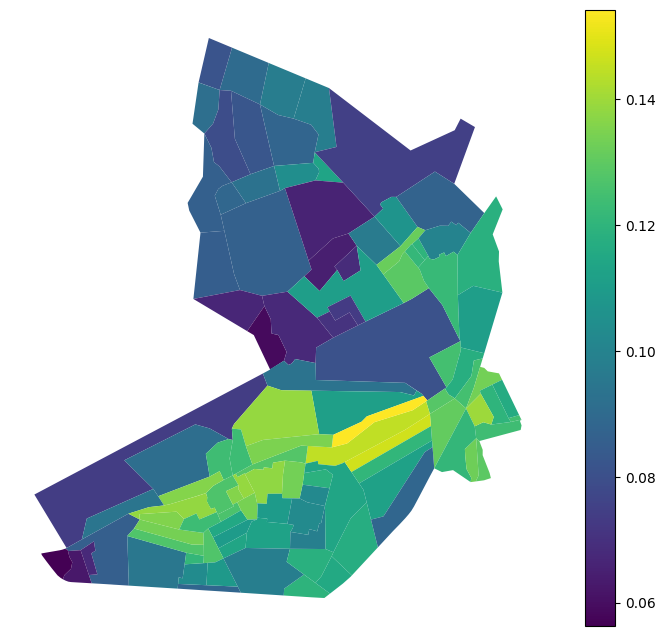

In [19]:
project_blocks[['geometry']].join(project_connectivity).plot('connectivity', legend=True, figsize=(10,8)).set_axis_off()

# 3D Map

In [2]:
import json
from pathlib import Path
import geopandas as gpd
import pandas as pd
import pydeck as pdk
from shapely.geometry import mapping

In [56]:
RESIDENTIAL_GEOJSON = Path('../geojson/residential_buildings_with_services.geojson')
NONRESIDENTIAL_GEOJSON = Path('../geojson/non_residential_buildings_with_services.geojson')
ROADS_GEOJSON = Path('../geojson/highway.geojson')
BOUNDARY_GEOJSON = Path('../geojson/project_boundary.geojson')
RECREATION_GEOJSON = Path("../geojson/recreation.geojson")

FLOOR_HEIGHT = 3.0

ATTR_RUS = {
    'is_living': 'Жилое здание',
    'population': 'Население',
    'building:levels': 'Этажность',
    'services': 'Сервисы',
    'highway_type': 'Тип дороги'
}

COLOR_RES_HEX = '#50C878'
COLOR_NONRES_HEX = '#6EAFF5'
COLOR_RECREATION = [0, 180, 0, 60]

SERVICE_LOOKUP = {
    21: "детский сад", 22: "школа", 23: "дом детского творчества", 25: "детские лагеря",
    26: "среднее специальное учебное заведение", 27: "высшее учебное заведение",
    28: "поликлиника", 29: "детская поликлиника", 30: "стоматологическая клиника",
    31: "фельдшерско-акушерский пункт", 32: "женская консультация", 33: "реабилитационный центр",
    34: "аптека", 35: "больница", 36: "роддом", 37: "детская больница", 38: "хоспис",
    39: "станция скорой медицинской помощи", 40: "травматологические пункты", 41: "морг",
    42: "диспансер", 44: "дом престарелых", 45: "центр занятости населения",
    46: "детские дома-интернаты", 47: "многофункциональные центры (мфц)", 48: "библиотека",
    49: "дворец культуры", 50: "музей", 51: "театр", 56: "кинотеатр", 57: "торговый центр",
    58: "аквапарк", 59: "стадион", 60: "ледовая арена", 61: "кафе", 62: "ресторан",
    63: "бар/паб", 64: "столовая", 65: "булочная", 67: "бассейн", 68: "спортивный зал",
    69: "каток", 73: "скалодром", 78: "полицейский участок", 79: "пожарная станция",
    81: "железнодорожный вокзал", 86: "автовокзал", 88: "выход метро", 89: "супермаркет",
    90: "продукты (магазин у дома)", 91: "рынок", 92: "хозяйственные товары",
    93: "одежда и обувь", 94: "бытовая техника", 95: "книжный магазин", 96: "детские товары",
    97: "спортивный магазин", 98: "почтовое отделение", 99: "пункт выдачи",
    100: "отделение банка", 101: "банкомат", 102: "адвокат", 103: "нотариальная контора",
    104: "парикмахер", 105: "салон красоты", 106: "общественная баня",
    107: "ветеринарная клиника", 108: "зоомагазин", 110: "гостиница", 111: "хостел",
    112: "база отдыха", 113: "памятник", 114: "церковь", 143: "санаторий", 132: "промышленная зона", 116: "котельная",
    85: "паркинг"
}

In [57]:
def safe_read_gdf(path: Path):
    if not path or not path.exists():
        print(f'[safe_read_gdf] Файл не найден: {path} — возвращаю пустой GeoDataFrame')
        return gpd.GeoDataFrame(columns=['geometry'])
    gdf = gpd.read_file(path)
    try:
        gdf = gdf.to_crs(epsg=4326)
    except Exception:
        pass
    return gdf


def hex_to_rgb_arr(hex_color: str, alpha_int: int = 255):
    s = hex_color.lstrip('#')
    lv = len(s)
    rgb = [int(s[i:i+lv//3], 16) for i in range(0, lv, lv//3)]
    return rgb + [int(alpha_int)]


def normalize_services_field(raw):
    if raw is None:
        return []
    items = []
    if isinstance(raw, (list, tuple)):
        items = list(raw)
    elif isinstance(raw, dict):
        items = [raw]
    elif isinstance(raw, str):
        s = raw.strip()
        try:
            parsed = json.loads(s)
            if isinstance(parsed, (list, tuple)):
                items = list(parsed)
            else:
                items = [parsed]
        except Exception:
            if ':' in s:
                a,b = s.split(':',1)
                if a.strip().isdigit():
                    items = [{'service': int(a.strip()), 'capacity': int(b.strip())}] if b.strip().isdigit() else [{'service': int(a.strip())}]
            elif s.isdigit():
                items = [int(s)]
            else:
                items = []
    elif isinstance(raw, (int, float)):
        items = [int(raw)]
    else:
        items = []

    out = []
    for it in items:
        if isinstance(it, (int, float)):
            sid = int(it)
            out.append({'service_id': sid, 'service_name': SERVICE_LOOKUP.get(sid, f'Неизвестный (ID {sid})'), 'capacity': None})
        elif isinstance(it, str) and it.isdigit():
            sid = int(it)
            out.append({'service_id': sid, 'service_name': SERVICE_LOOKUP.get(sid, f'Неизвестный (ID {sid})'), 'capacity': None})
        elif isinstance(it, dict):
            sid = None
            cap = None
            for k in ('service','service_id','id'):
                if k in it:
                    try:
                        sid = int(it[k])
                    except Exception:
                        sid = None
                    break
            for k in ('capacity','cap'):
                if k in it:
                    try:
                        cap = int(it[k])
                    except Exception:
                        cap = None
                    break
            if sid is None and len(it)==1:
                k0 = list(it.keys())[0]
                try:
                    sid_try = int(k0)
                    sid = sid_try
                    v = it[k0]
                    cap = int(v) if isinstance(v,(int,float)) else None
                except Exception:
                    pass
            if sid is not None:
                out.append({'service_id': sid, 'service_name': SERVICE_LOOKUP.get(sid, f'Неизвестный (ID {sid})'), 'capacity': cap})
            else:
                out.append({'service_id': None, 'service_name': str(it), 'capacity': None})
        else:
            out.append({'service_id': None, 'service_name': str(it), 'capacity': None})
    return out

In [58]:
def prepare_buildings(gdf: gpd.GeoDataFrame, is_residential: bool=True):
    if gdf.empty:
        return gdf

    if 'building:levels' in gdf.columns:
        gdf['building:levels'] = pd.to_numeric(gdf['building:levels'], errors='coerce')
    elif 'building:levels' in gdf.columns:
        gdf['building:levels'] = pd.to_numeric(gdf['building:levels'], errors='coerce')
    else:
        gdf['building:levels'] = pd.NA

    if 'population' in gdf.columns:
        gdf['population'] = pd.to_numeric(gdf['population'], errors='coerce')

    if 'services' in gdf.columns:
        gdf['services_normalized'] = gdf['services'].apply(normalize_services_field)
    else:
        gdf['services_normalized'] = [[] for _ in range(len(gdf))]

    def to_bool(v):
        if pd.isna(v):
            return False
        if isinstance(v, bool):
            return v
        s = str(v).strip().lower()
        return s in ('1','true','yes','да')

    if 'is_living' in gdf.columns:
        gdf['is_living_bool'] = gdf['is_living'].apply(to_bool)
    else:
        gdf['is_living_bool'] = is_residential

    gdf['height_m'] = (gdf['building:levels'].fillna(0) * FLOOR_HEIGHT).astype(float)

    base_hex = COLOR_RES_HEX if is_residential else COLOR_NONRES_HEX
    default_color = hex_to_rgb_arr(base_hex, alpha_int=255)
    yellow_color = hex_to_rgb_arr("#EED64F", alpha_int=255)
    violet_color = hex_to_rgb_arr("#E06BA2", alpha_int=150)

    yellow_ids = {21, 22}
    violet_ids = {28, 29, 35, 37}

    def get_color_by_services(services):
        if not services or not isinstance(services, list):
            return default_color

        for s in services:
            sid = None
            if isinstance(s, dict):
                sid = s.get('service_id')
            elif isinstance(s, (int, float)):
                sid = int(s)
            if sid in yellow_ids:
                return yellow_color
            elif sid in violet_ids:
                return violet_color
        return default_color

    gdf['color'] = [
        get_color_by_services(row.get('services_normalized', []))
        for _, row in gdf.iterrows()
    ]

    return gdf

In [59]:
res_gdf = safe_read_gdf(RESIDENTIAL_GEOJSON)
nonres_gdf = safe_read_gdf(NONRESIDENTIAL_GEOJSON)
roads_gdf = safe_read_gdf(ROADS_GEOJSON)
boundary_gdf = safe_read_gdf(BOUNDARY_GEOJSON)
recreation_gdf = safe_read_gdf(RECREATION_GEOJSON)

print(f'Жилые: {len(res_gdf)}, Нежилые: {len(nonres_gdf)}, Дороги: {len(roads_gdf)}, Границы: {len(boundary_gdf)}')
print(f'Рекреация: {len(recreation_gdf)}')

Жилые: 322, Нежилые: 44, Дороги: 172, Границы: 1
Рекреация: 3


In [60]:
res_gdf = prepare_buildings(res_gdf, is_residential=True)
nonres_gdf = prepare_buildings(nonres_gdf, is_residential=False)

buildings_gdf = pd.concat([res_gdf.assign(__source='residential'), nonres_gdf.assign(__source='nonresidential')], ignore_index=True, sort=False)

if buildings_gdf.empty:
    print('[info] Нет данных — вставляем демонстрационные объекты')
    from shapely.geometry import Polygon
    demo = gpd.GeoDataFrame([
        {'building:levels': 5, 'is_living': True, 'services': [{'service':57,'capacity':121}], 'geometry': Polygon([(37.615,55.755),(37.616,55.755),(37.616,55.756),(37.615,55.756)])},
        {'building:levels': 2, 'is_living': False, 'services': {'service':57,'capacity':121}, 'geometry': Polygon([(37.617,55.7555),(37.618,55.7555),(37.618,55.756),(37.617,55.756)])}
    ], crs='EPSG:4326')
    res_demo = prepare_buildings(demo, is_residential=True)
    buildings_gdf = res_demo.assign(__source='demo')

print(f'[info] Всего зданий: {len(buildings_gdf)}')

[info] Всего зданий: 366


In [61]:
features = []
for idx, row in buildings_gdf.iterrows():
    props = {
        'is_living_text': 'да' if bool(row.get('is_living_bool')) else 'нет',
        'building:levels': None if pd.isna(row.get('building:levels')) else int(row.get('building:levels')),
        'population': None if pd.isna(row.get('population')) else int(row.get('population')),
        'services': row.get('services_normalized', []),
        'height_m': float(row.get('height_m', 0)),
    }
    props['color'] = row.get('color', [128,128,128,115])
    geom = mapping(row.geometry)
    features.append({'type':'Feature','geometry':geom,'properties':props})

geojson_dict = {'type':'FeatureCollection','features':features}

def format_services_for_html(services_list):
    if not services_list:
        return '-'
    parts = []
    for s in services_list:
        if isinstance(s, dict):
            sid = s.get('service_id')
            name = s.get('service_name')
            cap = s.get('capacity')

            if name and cap is not None:
                parts.append(f"{name} (вместимость {cap})")
            elif name:
                parts.append(f"{name}")
            elif sid:
                name = SERVICE_LOOKUP.get(sid, f'Неизвестный (ID {sid})')
                if cap is not None:
                    parts.append(f"{name} (вместимость {cap})")
                else:
                    parts.append(f"{name}")
            else:
                parts.append(str(s))
        else:
            parts.append(str(s))
    return ', '.join(parts)

for feat in geojson_dict['features']:
    feat['properties']['services_html'] = format_services_for_html(feat['properties'].get('services', []))
    nf = feat['properties'].get('building:levels')
    pop = feat['properties'].get('population')
    feat['properties']['building:levels_text'] = str(nf) if nf is not None else '-'
    feat['properties']['population_text'] = str(pop) if pop is not None else '-'

In [62]:
if not boundary_gdf.empty:
    centroid = boundary_gdf.geometry.unary_union.centroid
    center = [centroid.x, centroid.y]
else:
    centroid = buildings_gdf.geometry.unary_union.centroid
    center = [centroid.x, centroid.y]

if not boundary_gdf.empty:
    layer_mask = pdk.Layer(
        "GeoJsonLayer",
        data=json.loads(boundary_gdf.to_json()),
        stroked=False,
        filled=True,
        get_fill_color=[250, 250, 250, 255],
        pickable=False
    )
else:
    layer_mask = None

layer_project = pdk.Layer(
    "BitmapLayer",
    data=None,
    image="../png/base_map_geo.png",
    bounds = [
        [30.70157978, 60.03532470],
        [30.70157978, 60.05335255],
        [30.73901616, 60.05335255],
        [30.73901616, 60.03532470],
    ],
    opacity=1,
)

layer_buildings = pdk.Layer(
    'GeoJsonLayer',
    data=geojson_dict,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=True,
    wireframe=False,
    get_fill_color='properties.color',
    get_line_color=[0, 0, 0],
    get_elevation='properties.height_m',
    elevation_scale=1,
    auto_highlight=True
)

if not roads_gdf.empty:
    layer_roads = pdk.Layer(
        'GeoJsonLayer',
        data=json.loads(roads_gdf.to_json()),
        stroked=True,
        filled=False,
        get_line_color=[140, 140, 140, 200],
        get_line_width=2,
        line_width_min_pixels=1,
        pickable=False
    )
else:
    layer_roads = None

if not boundary_gdf.empty:
    layer_boundaries = pdk.Layer(
        'GeoJsonLayer',
        data=json.loads(boundary_gdf.to_json()),
        stroked=True,
        filled=False,
        get_line_color=[80, 80, 80, 200],
        get_line_width=2,
        line_width_min_pixels=2,
        pickable=False
    )
else:
    layer_boundaries = None

if not recreation_gdf.empty:
    layer_recreation = pdk.Layer(
        'GeoJsonLayer',
        data=json.loads(recreation_gdf.to_json()),
        stroked=False,
        filled=True,
        get_fill_color=COLOR_RECREATION,
        pickable=False
    )
else:
    layer_recreation = None

view_state = pdk.ViewState(
    latitude=center[1],
    longitude=center[0],
    zoom=14,
    pitch=45,
    bearing=0
)

tooltip = {
    'html': f"{ATTR_RUS['is_living']}: " + '{properties.is_living_text}' + '<br/>' +
            f"{ATTR_RUS['building:levels']}: " + "{properties.building:levels_text}" + '<br/>' +
            f"{ATTR_RUS['population']}: " + "{properties.population_text}" + '<br/>' +
            f"{ATTR_RUS['services']}: " + "{properties.services_html}",
    'style': {
        'backgroundColor': 'rgba(255, 255, 255, 0.9)',
        'color': '#111',
        'maxWidth': '360px'
    }
}

layers = []
if layer_mask:
    layers.append(layer_mask)
layers.append(layer_buildings)
layers.append(layer_project)
if layer_recreation:
    layers.append(layer_recreation)
if layer_roads:
    layers.append(layer_roads)
if layer_boundaries:
    layers.append(layer_boundaries)

r = pdk.Deck(
    layers=layers,
    initial_view_state=view_state,
    tooltip=tooltip,
    map_style='light'
)

out_html = '../html/3d_visualization.html'
r.to_html(out_html, notebook_display=False)
print(f'[done] Экспортировано в HTML: {out_html}')

/tmp/ipykernel_1687/2979714085.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = boundary_gdf.geometry.unary_union.centroid


[done] Экспортировано в HTML: ../html/3d_visualization.html
